# CSCI 3202, Spring 2022: Final Coding Project

---


This is your final programming project for CSCI 3202. It is due on Canvas by **11:59 PM on Saturday April 30**.  Your solutions to theoretical questions should be done in Markdown/LateX directly below the associated question. Your solutions to computational questions should include any relevant Python code, as well as results and any written commentary.

You have two options for completing your final project for this course. The first option is presented in this notebook and involves implementing a reinforcement learning algorithm and producing a five-minute video that explains your process of solving this problem. The second option is to design your own project that includes the algorithms we've discussed since the midterm - Bayes Nets, Hidden Markov Models, Markov Decision Processes, or Reinforcement Learning - or an algorithm related to one of these that we haven't discussed in class. Your project also needs to include some kind of analysis of how it performed on a specific problem. If you're interested in the design your own project option, you need to discuss your idea with one of the course instructors to get approval. If you do a project without getting approval, you will receive a 0 regardless of the quality of the project. You will also need to produce a short, five-minute video that explains your project.

**The rules:**

1. Choose EITHER the given problem to submit OR choose your own project topic. 

2. If you choose your own project topic, please adhere to the following guidelines:
- The project needs to be approved by the course instructors.
- The project needs to include one of the algorithms we've discussed since the midterm - Bayes Nets, HMMs, MDPs, or Reinforcement Learning - or an algorithm that we haven't discussed in class. 
- If you do your own project without prior approval, you will receive a 0 for this project.
- Your project code, explanation, and results must all be contained in a Jupyter notebook. 

3. All work, code and analysis must be **your own**.
4. You may use your course notes, posted lecture slides, textbook, in-class notebooks and homework solutions as resources.  You may also search online for answers to general knowledge questions, like the form of a probability distribution function, or how to perform a particular operation in Python. You may not use entire segments of code as solutions to any part of this project, e.g. if you find a Python implementation of policy iteration online, you can't use it.
5. You may **not** post to message boards or other online resources asking for help.
6. **You may not collaborate with classmates or anyone else.**
7. This is meant to be like a coding portion of your final exam. So, we will be much less helpful than we typically am with homework. For example, we will not check answers, help debug your code, and so on.
8. If you have a question, post it first as a **private** Piazza message. If we decide that it is appropriate for the entire class, then we will make it a public post (and anonymous).
9. If something is left open-ended, it is probably because we intend for you to code it up however you want, and only care about the plots/analysis we see at the end. Feel free to ask clarifying questions though.

Violation of these rules will result in an **F** and a trip to the Honor Code council.

---
**By writing your name below, you agree to abide by these rules:**

**Your name:** Ethan Meyer

---



In [1]:
# Importing all necessary libaries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

<img src="images/title.png">

[Link to Project Video](https://youtu.be/aGq7ML_Eusc)



# An Entropy-Based Approach to Wordle
## 1. Introduction
### 1.1 What is Wordle?

**Wordle** is a once a day word game offered by the [New York Times](https://www.nytimes.com/games/wordle/index.html) that challenges players to guess a 5 character word within 6 guesses. After each guess, players recieve information on the letters of their guess via the following encoding:

<img src="images/Explainer.png" alt="Wordle Explainer" width="400" height="500"/>


### 1.2 The Basics of Entropy

In the context of Information Theory, the **entropy** of a random variable measures the average level of "information", "surprise", or "uncertainty" inherent to the variable's possible outcomes. The intuition behind quantifying entropy is the idea of balancing how much information an outcome provides with how likely that outcome is to occur. Essentially, rare outcomes provide high information but have a low probability while common outcomes have a high probability but provide little information. Now, we must determine how to quantify these two measures.

**Probability:** Trivially, we can quantify the probability of an outcome by simply determining its probability:
$$ P =  P(\text{outcome}) $$

**Information:** Intuitively, we know that Information is inversely proportional to probability, that is, when $P(\text{outcome})$ is close to $0$, the information is high, but if $P(\text{outcome})$ is close to $1$, the information is low. We describe this by the relationship:
$$I = \log_2(\frac{1}{P(\text{outcome})}) $$

**Entropy:**
And so, we can calculate the entropy of a discrete random variable $X$, having possible outcomes $x_{1},...,x_{n}$, which occur with probability $P(x_{1}),...,P(x_{n}),P(x_{1}),...,P(x_{n})$ as:

$$
\begin{align}
    H(X) &= \sum_{i=1}^{n} {P(x_i) \cdot \log_2(\frac{1}{P(x_i)}}) \\
         &= \sum_{i=1}^{n} {P(x_i) \cdot (\log_2(1) - \log_2(P(x_i)))} \\
         &= \sum_{i=1}^{n} {P(x_i) \cdot (- \log_2(P(x_i))} \\
         &= - \sum_{i=1}^{n} {P(x_i) \cdot \log_2(P(x_i)} \\
\end{align}
$$

### 1.3 Data Sources
For this project, I chose to differentiate the data sources between allowable guesses and possible answers. The rationale behind this decision was that I wanted to limit the solution space while giving myself the most options possible in terms of guesses.  

**Guess List:** List of 12,953 words allowed as guesses in Wordle.

**Answer List:** List of 2,309 words that have been or will be answers to Wordle.

**Source:** [GitHub](https://gist.github.com/cfreshman/dec102adb5e60a8299857cbf78f6cf57)

In [2]:
guess_list = list(pd.read_csv("guess_bank.txt")["Word"])
answer_list = list(pd.read_csv("answer_bank.txt")["Word"])

## 2. Objectives
### 2.1 Wordle Opening Strategy
1. Determine the best first word (i.e. word w/ highest entropy)
2. For each possible resulting pattern, determine best second word

### 2.2 WordleAI
Create an AI that has two modes:
1. Helper: Interacts with user providing best guesses at each step
2. Autonomous: Solves puzzle alone

## 3. Approach and Implementation

<br>

### 3.1 Calculating Entropy
In the context of Wordle, outcomes are characterized as the resulting pattern following a guess. We can determine the probability of seeing some pattern $p_i$ as 

$$ P(p_i) = \frac{\text{# words w/ Pattern(word)} = p_i}{\text{Total # of words}}$$

Seeing as there are 5 characters each with 3 possible colors ( 🟩, 🟨, or ⬛ ), there are theoretically $3^5 = 243$ possible outcomes (theoretically because patterns like 🟩 🟩 🟩 🟩 🟨 are impossible). And so, we can determine the entropy of some $guess$ having possible outcomes $p_{1},...,p_{243}$ as:

$$
\begin{align}
    H(guess) &= - \sum_{i=1}^{243} {P(p_i) \cdot \log_2(P(p_i)}) \\
         &= - \sum_{i=1}^{243} \frac{\text{# words w/ Pattern(word)} = p_i}{\text{Total # of words}} \cdot \log_2(\frac{\text{# words w/ Pattern(word)} = p_i}{\text{Total # of words}}) \\
\end{align}
$$ 

**Calculating Pattern Between Words:** This first thing we need for our approach is a function that calculates an output pattern given a guess and target word.

In [1]:
def calc_pattern(guess_word, target_word):
    # INPUTS: "guess" and "target" words 
    # OUTPUTS: array containing their resulting pattern
    # LEGEND: 0=Gray, 1=Yellow, 2=Green
    
    num_chars = len(guess_word) # Number of characters in string
    pattern = ["0"] * num_chars # variable to store result
    
    for guess_idx in range(num_chars): # Iterate through each of the characters in the string
        
        if guess_word[guess_idx] == target_word[guess_idx]: # If the letters match and are in the same position
            pattern[guess_idx] = "2" # Mark pattern as "Green"
        
        else: # Otherwise
            for target_idx in range(num_chars):
                if (guess_idx != target_idx):
                    if (guess_word[guess_idx] == target_word[target_idx]) and (guess_word[target_idx] != target_word[target_idx]): # If letter in word but other position
                        pattern[guess_idx] = "1" # Mark as yellow
                        target_word = target_word[0:target_idx] + '_' + target_word[target_idx + 1:]
                        break   
        
    return pattern

# A few test cases
assert(calc_pattern("words","words") == ["2","2","2","2","2"]) # Strings match -> All greens
assert(calc_pattern("guess","wordy") == ["0","0","0","0","0"]) # No characters match -> All grays
assert(calc_pattern("wordy","words") == ["2","2","2","2","0"]) # Last character doesn't match -> 4 Greens, 1 Gray

**Calculating All Patterns:** The next thing we will need is a function to determine the resulting patterns we would observe given a guess and answer word for all possible answer words.

In [4]:
def get_patterns(guess_word, answer_list):
    # INPUTS: guess_word and list of all possible answers
    # OUTPUTS: returns DataFrame with each possible answer and its resulting pattern given guess_word
    
    num_words = len(answer_list)
    pattern_tracker = [''] * num_words

    for word_num, answer_word in enumerate(answer_list): # Iterate through all possible answers
        result_array = calc_pattern(guess_word, answer_word) # Determine pattern

        result_string = "" # Convert array into string

        for letter in result_array:
            result_string += letter

        pattern_tracker[word_num] = result_string    # Store result
        
    result_df = pd.DataFrame({"Target":answer_list, "Guess":guess_word,"Pattern":pattern_tracker }) # Formatting into DataFrame

    return result_df

**Determing All Possible Patterns:** Before iterating across all possible patterns, we will need to generate the list containing all possible patterns.

In [5]:
def create_all_ternary_strings(n, lst = [""]):
    # INPUTS: n | # of chars to append remaining, lst | list so far
    # OUTPUTS: returns all possible ternary strings (elements are 0,1, or 2) of length n
    # LEGEND: 0=Gray, 1=Yellow, 2=Green
    # Adapted from similar approach: https://www.geeksforgeeks.org/generate-all-the-binary-strings-of-n-bits/ 
     
    if (n == 0): # Reached base case
        return lst # Return set of strings
    else:
        new_lst = []
        for idx in range(len(lst)): #For each string, add a 0, a 1, and a 2 to the end
            string = lst[idx] 
            
            string_and_0 = string + "0"
            string_and_1 = string + "1" 
            string_and_2 = string + "2"
            
            new_lst.append(string_and_0)
            new_lst.append(string_and_1)
            new_lst.append(string_and_2)

        return create_all_ternary_strings(n - 1, new_lst) # Recursive call

all_possible_patterns = create_all_ternary_strings(5) # Variable that stores all possible patterns
assert(len(all_possible_patterns) == 3**5)

**Determining Pattern Distribution:** Now, we will need to write a function that determines the distrbution of resulting patterns given a specific guess.

In [7]:
def get_entropy(p):
    # INPUTS: p
    # OUTPUTS: -p * np.log(p)
    if p == 0:
        return 0
    else:
        return -p * np.log(p) / np.log(2)

def get_pattern_distribution(guess_word, answer_list):
    # INPUTS: guess_word and list of all possible answers
    # OUTPUTS: returns DataFrame containing each pattern and the count, probability, and entropy of words in answer_list that have that pattern given guess_word
    
    result_df = get_patterns(guess_word, answer_list) # Determing resulting pattern for each possible answer given guess_word 
    
    num_words = len(answer_list) # Number of words in answer_list
    num_possible_patterns = len(all_possible_patterns) # Number of possible patterns

    pattern_distribution_counter = np.zeros(num_possible_patterns) # Array to track results
    p_tracker = np.empty(num_possible_patterns)
    entropy_tracker = np.empty(num_possible_patterns)

    for idx, pattern in enumerate(all_possible_patterns):
        count = np.sum(result_df["Pattern"] == pattern)
        pattern_distribution_counter[idx] = count
        p_tracker[idx] = count / num_words
        entropy_tracker[idx] = get_entropy(count / num_words)

    pattern_distribution = pd.DataFrame({"Pattern":all_possible_patterns,"Count":pattern_distribution_counter,"p":p_tracker,"Entropy":entropy_tracker})

    return pattern_distribution

**Calcuating Entropy:** Finally, we need a function that returns just the value of the entropty given a guess word and answer list.

In [474]:
def get_entropy_slow(guess_word, answer_list):
    # INPUTS: guess word and answer list
    # OUTPUTS: Entropy of guess word
    
    pattern_distribution = get_pattern_distribution(guess_word, answer_list) # Get values by pattern

    return np.sum(pattern_distribution["Entropy"]) # Sum across all patterns

**Improving Runtime Performance:** Becuase of the number of times we need to calculate the entropy of a word, we will a function that is optimized for performance at the detriment of readability.

In [475]:
def get_entropy_superfast(guess_word, answer_list):
    # 1. For each word in the answer_list, calculate the resulting pattern when "guess_word" is guessed
    num_words = len(answer_list)
    pattern_tracker = [''] * num_words

    for word_num, answer_word in enumerate(answer_list): # Iterate through all of the possible answers
        result_array = calc_pattern(guess_word, answer_word) # Calculate pattern

        result_string = "" # Convert to a string
        for letter in result_array:
            result_string += letter

        pattern_tracker[word_num] = result_string  # Store in array
    
    pattern_tracker = np.array(pattern_tracker)
    
    # 2. Determine the distribution and entropy of all possible answer words across the possible patterns
    _, counts = np.unique(pattern_tracker, return_counts=True)
    entropy_total = 0
    
    for c in counts:
        p = c/num_words
        entropy_total += -p * (np.log(p) / np.log(2)) # Formula for entropy of an individual pattern
        
    return entropy_total

In [484]:
from datetime import datetime
import math

guess_word = "crane"

start = datetime.now()
for _ in range(50):
    e1 = get_entropy_slow(guess_word, answer_list)
stop = datetime.now()
slow_time = (stop - start).total_seconds()
print("Slow:", slow_time, "secs")

start = datetime.now()
for _ in range(50):
    e2 = get_entropy_superfast(guess_word, answer_list)
stop = datetime.now()
fast_time = (stop - start).total_seconds()
print("Fast:", fast_time, "secs")

print(round(slow_time/fast_time, 3),"times faster")

assert(math.isclose(e1,e2))

Slow: 4.944202 secs
Fast: 0.613153 secs
8.064 times faster


### 3.2 Wordle Opening Strategy
1. **Compute** Entropy for all possible guesses given the original list of possible answers
2. **Select** and play guess with highest entropy (i.e. best first guess)
3. For each possible resulting pattern, **filter** list of answers based on pattern
4. **Compute** Entropy for all possible guesses given list of remaining possible answers
5. **Select** guess with highest entropy (i.e. best second guess given pattern)

#### 3.2.1 Best First Guess

In [15]:
entropy_tracker = np.empty(len(guess_list)) # Array to store results of entropy for each guess

for idx, guess_word in enumerate(guess_list): # Iterate through all possible guesses
    entropy_val = get_entropy_fast(guess_word, answer_list) # Compute entropy of guess

    entropy_tracker[idx] = entropy_val
    
best_idx = np.argmax(entropy_tracker)
best_entropy = entropy_tracker[best_idx]
best_first_guess = guess_list[best_idx]

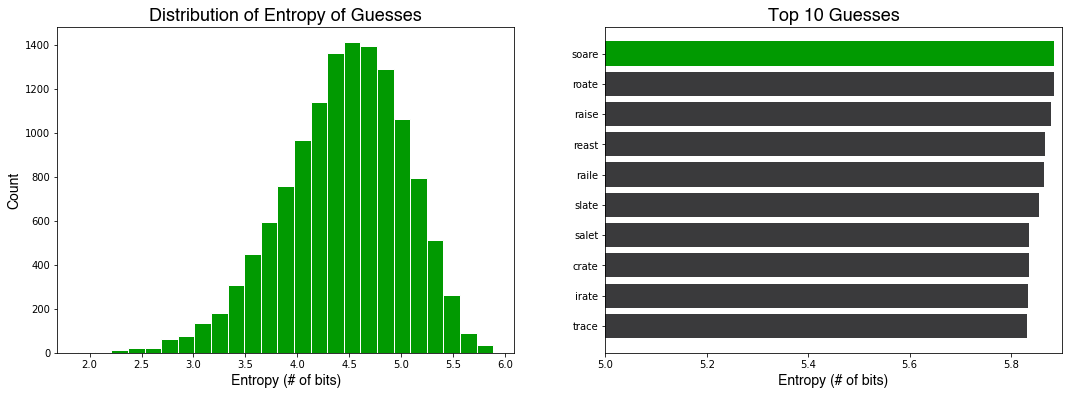

In [99]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(18,6))

# Histogram of Entropy
ax[0].hist(entropy_tracker, bins=25, color="#019a01", edgecolor="white")
ax[0].set_title("Distribution of Entropy of Guesses", size=18, fontname="Helvetica", weight="bold")
ax[0].set_xlabel("Entropy (# of bits)", size=14, fontname="Helvetica", weight="bold")
ax[0].set_ylabel("Count", size=14, fontname="Helvetica", weight="bold")

# Top 10 Guesses
top_10_idxs = np.argsort(entropy_tracker)[-10:]
top_10_entropy = entropy_tracker[top_10_idxs]
top_10_guesses = np.array(guess_list)[top_10_idxs]
hbars = ax[1].barh(top_10_guesses, top_10_entropy, color=["#3a3a3c"]*9 + ['#019a01'])
ax[1].set_title("Top 10 Guesses", size=18, fontname="Helvetica", weight="bold")
ax[1].set_xlabel("Entropy (# of bits)", size=14, fontname="Helvetica", weight="bold")
ax[1].set_xlim((5,5.9))

plt.show()

<img src="images/Guess_1.png" alt="Best First Guess" width="800" height="100"/>


#### 3.2.2 Best Second Guesses
After determining the best initial guess, I iterated through each of the possible resulting patterns and found the best second guess given that pattern. Due to the execution time of this section of code (2+ hours), I have not included it in this notebook. However, it is included in this repository under the filename `2nd_guess.py`.

After computing all best second guesses, I created a cheat sheet including all the results:


<img src="images/cheat sheet.svg">

<svg src="1.svg"></svg>

### 3.3 Wordle AI
1. **Compute** Entropy for all possible guesses given list of answers
2. **Select** and play guess with highest entropy
3. **Filter** list of answers based on resulting pattern
4. **Repeat** until puzzle solved or out of turns

In [485]:
class wordle_ai:
    def __init__(self, mode, answer_word=None, print_bool=True):
        # Reading in data
        self.load_data()
        
        # mode = "helper": Human-interactive
        # mode = "autonomous": AI plays by itself
        self.mode = mode
        self.answer_word = answer_word
        self.print_bool = print_bool

        # Instantiating appropriate variables
        self.turn_number = 0
        self.max_turns = 6
        self.game_over = False
        self.current_pattern = None
        self.pattern_list = []
        self.game_result = None

        
    def load_data(self):
        answer_bank = pd.read_csv("answer_bank.txt")
        self.answer_list = list(answer_bank["Word"])

        guess_bank = pd.read_csv("guess_bank.txt")
        self.guess_list = list(guess_bank["Word"])
        
        self.second_guess_df = pd.read_csv("2nd_guess.csv",dtype=str, index_col=0)

    def play_game(self):
        while self.game_over == False:
            self.turn_number += 1
            if self.turn_number > 6:
                self.game_over = True
                self.game_result = "Lose"
            else:
                self.play_turn()
                
        if self.print_bool:
            self.print_summary()
        
        return(self.game_result, self.turn_number)
    
    def play_turn(self):
        best_guess = self.get_best_guess() # Get best guess via helper function
        
        if self.print_bool:
            print("\nGuess # " + str(self.turn_number) +":", best_guess)
        
        if self.mode == "helper": # If mode is set to "helper"            
            print("Please enter the resulting pattern via the follwing encoding:") # Ask user to input resulting pattern
            green_sq = "\U0001F7E9"
            yellow_sq = "\U0001F7E8"
            gray_sq = "\U00002B1B"

            print("0:", gray_sq)
            print("1:", yellow_sq)
            print("2:", green_sq)

            self.current_pattern = input()
        
        elif self.mode == "autonomous": # If mode is set to "autonomous"
            pattern_array = calc_pattern(best_guess, self.answer_word) # Calculate pattern based on given answer_word
            
            pattern_string = "" # Convert to a string
            for letter in pattern_array:
                pattern_string += letter
            
            self.current_pattern = pattern_string    

        self.handle_pattern(best_guess, self.current_pattern) # Filter possible answers based on current_pattern
    
    def handle_pattern(self, best_guess, resulting_pattern):
        self.pattern_list.append(resulting_pattern) # Append pattern to list
        
        if resulting_pattern == "22222": # All green squares: game is over
            self.game_over = True
            self.game_result = "Win"
        
        else:
            patterns_df = get_patterns(best_guess, self.answer_list) # Get pattern for each possible answer based on best guess
            remaining_possible_answers = list(patterns_df[patterns_df["Pattern"] == resulting_pattern]["Target"]) # Filter down remaining answers

            self.answer_list = remaining_possible_answers
    
    def get_best_guess(self):
        answer_list = self.answer_list

        if self.turn_number == 1: # Shortcut for 1st Guess
            return "soare"
        
        elif self.turn_number == 2: # Shortcut for 2nd Guess
            return list(self.second_guess_df[self.second_guess_df["Pattern"] == self.current_pattern]["2nd Guess"])[0]
            
        else:
            entropy_tracker = np.empty(len(guess_list))

            for idx, guess_word in enumerate(guess_list): # Iterate through all guesses
                entropy_val = get_entropy_superfast(guess_word, answer_list) # Calculate entropy

                entropy_tracker[idx] = entropy_val
            
            best_idx = np.argmax(entropy_tracker) # Choose guess with highest entropy
            best_entropy = entropy_tracker[best_idx]
            best_guess = guess_list[best_idx]

            # Tie Breaking Procedure
            if np.sum(entropy_tracker == best_entropy) > 1: # Multiple best guesses... should selectively choose guesses that are also possible answers
                candidate_guesses = np.array(guess_list)[entropy_tracker == best_entropy] # Array og guesses that tied for best entropy
                
                if self.mode == "helper":
                    choice_of_guesses = [best_guess] # Array to hold all candidate guesses that are possible answers
                    
                    for guess_word in candidate_guesses: # Iterate through candidates
                        if guess_word in self.answer_list and guess_word != best_guess: # If they are a possible answer
                            choice_of_guesses.append(guess_word) # Append to choices
                    
                    if len(choice_of_guesses) > 1: # If we found a candidate guess that is a possible answer
                        print("\nMultiple Best Guesses")
                        print("Options", choice_of_guesses)
                        print("Please enter your choice:")
                        best_guess = input() # Allow user to chose
                        assert(best_guess in choice_of_guesses)
                    
                
                elif self.mode == "autonomous": # If mode is set to autonomous
                    for guess_word in candidate_guesses: # Check to see if any candidate guesses are possible answers
                        if guess_word in answer_list:
                            return guess_word

            return best_guess
    
    def print_summary(self):
        # Prints nicely formatted "Wordle"-like summary of game
        green_sq = "\U0001F7E9"
        yellow_sq = "\U0001F7E8"
        gray_sq = "\U00002B1B"

        print("\n")
        print(" WORDLE ")
        for string in self.pattern_list:
            colored_pattern = string.replace('2', green_sq).replace('1', yellow_sq).replace('0', gray_sq)
            print(colored_pattern)
        
        print("You " + self.game_result + "!" )
    

#### 3.3.1 WordleAI Helper Mode
Try out the "Helper" mode by going opening a game of [Wordle](https://www.nytimes.com/games/wordle/index.html) and then executing the cell below. 

In [492]:
wordle_bot = wordle_ai(mode = "helper")
wordle_bot.play_game()


Guess # 1: soare
Please enter the resulting pattern via the follwing encoding:
0: ⬛
1: 🟨
2: 🟩
00110

Guess # 2: riyal
Please enter the resulting pattern via the follwing encoding:
0: ⬛
1: 🟨
2: 🟩
10011

Multiple Best Guesses
Options ['aahed', 'larva']
Please enter your choice:
larva

Guess # 3: larva
Please enter the resulting pattern via the follwing encoding:
0: ⬛
1: 🟨
2: 🟩
22222


 WORDLE 
⬛⬛🟨🟨⬛
🟨⬛⬛🟨🟨
🟩🟩🟩🟩🟩
You Win!


('Win', 3)

#### 3.3.2 Wordle AI Autonomous Mode

In [494]:
autonomous_ai = wordle_ai(mode = "autonomous", answer_word = "larva")
autonomous_ai.play_game()


Guess # 1: soare

Guess # 2: riyal

Guess # 3: larva


 WORDLE 
⬛⬛🟨🟨⬛
🟨⬛⬛🟨🟨
🟩🟩🟩🟩🟩
You Win!


('Win', 3)

## 4. Testing and Results

### 4.1 WordleAI Standalone Performance

To test the overall performance of my AI, I tested it with every single answer in the dataset and recorded the results which are displayed below.

In [ ]:
num_trials = len(answer_list) # Number of answers in list

result_tracker = [''] * num_trials # Arrays to track stats of games
num_turns_tracker = np.empty(num_trials)

for idx, answer_word in enumerate(answer_list):
    wordle_bot = wordle_ai(mode = "autonomous", answer_word = answer_word, print_bool=False) # Instantiate AI
    result, num_turns = wordle_bot.play_game() # Play game
    
    result_tracker[idx] = result # Record results
    num_turns_tracker[idx] = num_turns

ai_performance_df = pd.DataFrame({"Answer":answer_list,"Result":result_tracker,"# Turns":num_turns_tracker})

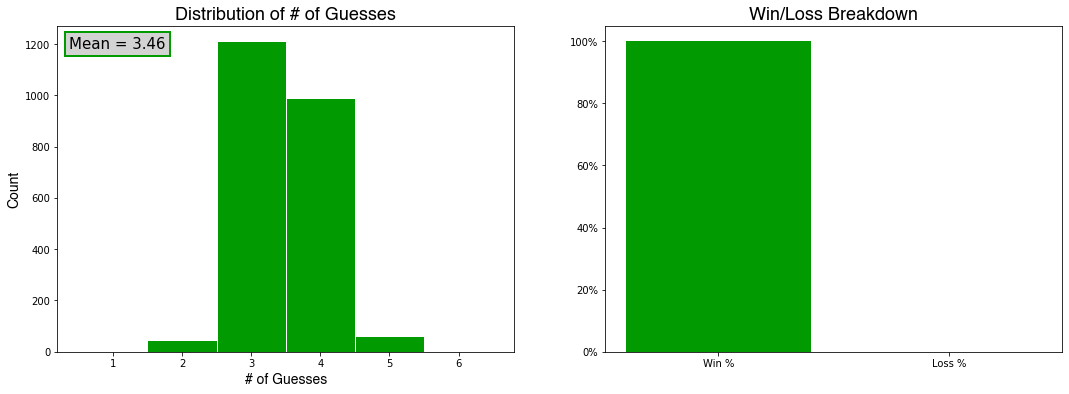

In [383]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(18,6))
import matplotlib.ticker as mtick

# Histogram of # of Guesses
ax[0].hist(ai_performance_df["# Turns"], bins=[1,2,3,4,5,6,7], align="left", color="#019a01", edgecolor="white")
ax[0].set_title("Distribution of # of Guesses", size=18, fontname="Helvetica", weight="bold")
ax[0].set_xlabel("# of Guesses", size=14, fontname="Helvetica", weight="bold")
ax[0].set_ylabel("Count", size=14, fontname="Helvetica", weight="bold")
ax[0].text(1.07, 1200, "Mean = 3.46", ha="center", va="center", size=15,bbox=dict(boxstyle="square,pad=0.3", fc="lightgray", ec="#019a01", lw=2))

# Win/Loss Breakdown
win_pct = 100 * np.sum(ai_performance_df["Result"] == "Win") / num_trials
loss_pct = 100 * np.sum(ai_performance_df["Result"] == "Lose") / num_trials
ax[1].bar(["Win %","Loss %"],[win_pct, loss_pct], color = ['#019a01',"#3a3a3c"])

ax[1].set_title("Win/Loss Breakdown", size=18, fontname="Helvetica", weight="bold")
ax[1].yaxis.set_major_formatter(mtick.PercentFormatter())

plt.show()

### 4.2 WordleAI Relative Performance
As a last measure, I wanted to see how my AI performed relative to human players. Thankfully, I discovered [WordleStats](https://twitter.com/WordleStats), an automated Twitter account that posts daily statistics on Wordle games. And so, I scraped the data from the last 50 days worth of games, and visualized how WordleAI performs relative to humans. 

In [403]:
human_data = pd.read_csv("human_scores.csv")
test_answer_words = list(human_data["Answer"])

num_trials = len(test_answer_words) # Number of answers in list

result_tracker = [''] * num_trials # Arrays to track stats of games
num_turns_tracker = np.empty(num_trials)

for idx, answer_word in enumerate(test_answer_words):
    wordle_bot = wordle_ai(mode = "autonomous", answer_word = answer_word, print_bool=False) # Instantiate AI
    result, num_turns = wordle_bot.play_game() # Play game
    
    result_tracker[idx] = result # Record results
    num_turns_tracker[idx] = num_turns

/var/folders/fm/kvyzn4_n7bsb1lc6yth8gqh00000gn/T/ipykernel_79890/1667936442.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(test_answer_words,rotation = 45);


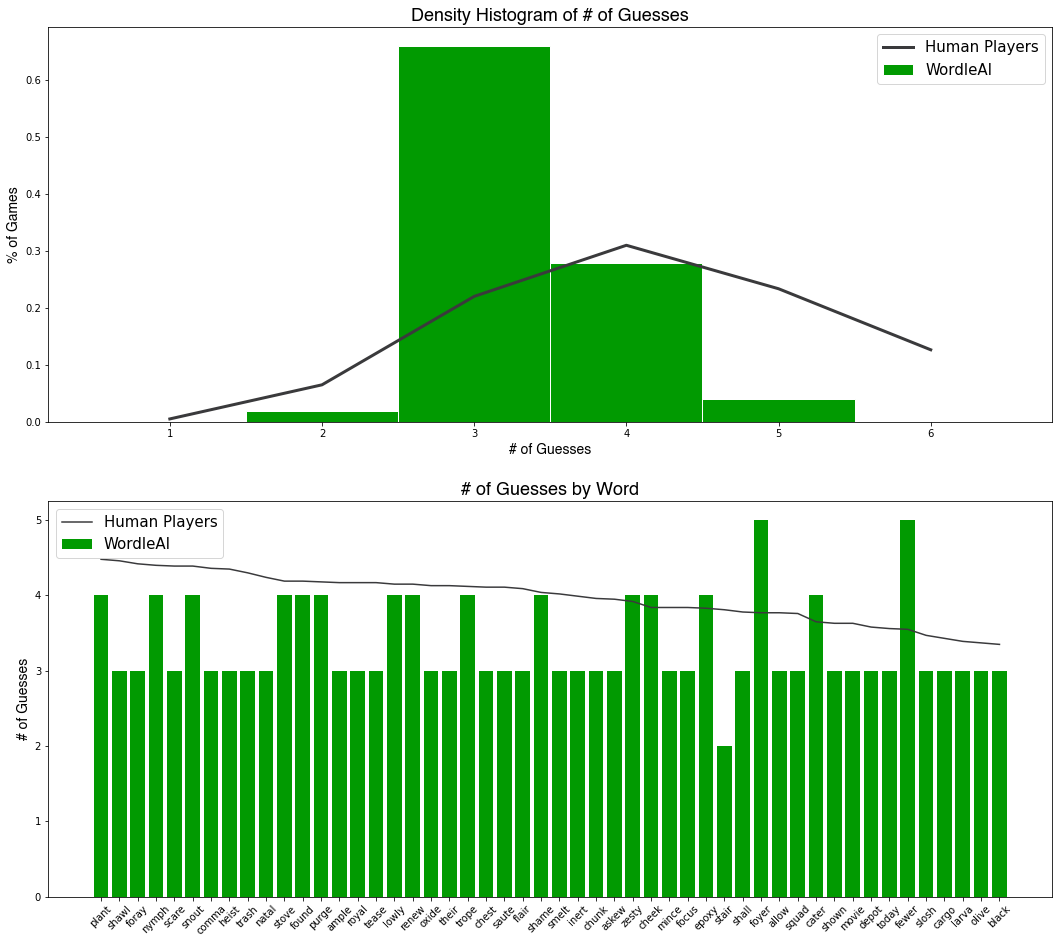

In [473]:
fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(18,16))

# Human vs AI # guesses distribution
human_score_dist = list(human_data.iloc[:, 1:7].mean(axis=0)/100)
ax[0].hist(num_turns_tracker, bins=[1,2,3,4,5,6,7], align="left", color="#019a01", edgecolor="white", density=True, label="WordleAI")
ax[0].plot([1,2,3,4,5,6],human_score_dist, color = "#3a3a3c", label="Human Players", linewidth=3)
ax[0].set_title("Density Histogram of # of Guesses", size=18, fontname="Helvetica", weight="bold")
ax[0].set_xlabel("# of Guesses", size=14, fontname="Helvetica", weight="bold")
ax[0].set_ylabel("% of Games", size=14, fontname="Helvetica", weight="bold")
ax[0].legend(prop={'size': 15})

# Human vs AI # guesses by game
ax[1].bar(test_answer_words,num_turns_tracker, color="#019a01",label="WordleAI")
ax[1].plot(human_data["Avg # Guesses"], color="#3a3a3c",label="Human Players")
ax[1].set_xticklabels(test_answer_words,rotation = 45);
ax[1].set_title("# of Guesses by Word", size=18, fontname="Helvetica", weight="bold")
ax[1].set_ylabel("# of Guesses", size=14, fontname="Helvetica", weight="bold")
ax[1].legend(prop={'size': 15})

plt.show()

# Conclusion

**Notes**
- Successful in both objectives 
    - Opening Strategy & Wordle AI
- Entropy-Based approach is clearly effective in outplaying humans
- Possible performance improvements exist

**Future Work**
- Tuning aggressiveness of guess selection
- Increasing depth of entropy search

# References
- Wordle: New York Times, Josh Wardle
- Inspiration: 3blue1brown, Diego Unzueta
- Info on Entropy: Wikipedia,  Jason Brownlee
- Wordle User Data: WordleStats
- Wordle Guess and Answer Lists: Cyrus Freshman